## Modeling and Comparing different algorithms

In this notebook, we model and compare different algorithms for collaborative filtering using the surprise library.

### Collaborative Filtering

see [Build a Recommendation Engine With Collaborative Filtering](https://realpython.com/build-recommendation-engine-collaborative-filtering/)

Collaborative filtering takes users' reactions to items into account. You can get recommendations based on the items you liked, and the items similar users liked. There are different ways to determine which users are similar. The dataset has to contain a set of items and a set of users, who reacted to the items (in our case explicit user ratings).

### Surprise library

[Surprise](https://surprise.readthedocs.io/en/stable/#) is a Python scikit for recommender systems. Surprise offers a variety of different prediction algorithms, including SVD (Singular value decomposition). It also provides various tools for cross validation and parameter search. You can choose from different similarity measures and accuracy metrics.

### Task: Which algorithm yields the best results for our dataset?

### Import Packages

In [12]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
from surprise import Dataset
from surprise import Reader

from surprise import BaselineOnly
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import SVD
from surprise import accuracy
from surprise import SlopeOne
from surprise import SVDpp
from surprise import NMF
from surprise import NormalPredictor
from surprise import KNNBaseline
from surprise import KNNWithZScore
from surprise import CoClustering

from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV

from surprise import accuracy

RSEED = 42

### Load data and match movie ids in ratings with movie ids in df_features

This guarantees that the datasets used for (pre-)recommendations and for diversity match.

In [14]:
movies = pd.read_csv('../data/ml-latest-small/movies.csv')
ratings = pd.read_csv('../data/ml-latest-small/ratings.csv')

In [15]:
ratings.describe()
ratings.movieId.nunique()

9724

In [16]:
df = pd.read_csv('../data/df_features.csv')
movieIds = df.movieId.to_list()

len(movieIds)

9543

In [17]:
ratings = ratings[ratings['movieId'].isin(movieIds)]
ratings.movieId.nunique()

9525

#### Define Reader and load data

In [18]:
reader = Reader(rating_scale=(0.5,5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

### First Benchmark to get a feeling for the algorithms

In [ ]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

In [20]:
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

,test_rmse,fit_time,test_time
Algorithm,,,
SVDpp,0.867468,176.694240,4.538006
BaselineOnly,0.876681,0.073831,0.095690
SVD,0.880194,2.061921,0.125738
KNNBaseline,0.882222,0.090767,1.032155
KNNWithMeans,0.903023,0.042425,0.884119
KNNWithZScore,0.906356,0.075481,1.007733
SlopeOne,0.911080,1.497218,3.606264
NMF,0.934531,2.447764,0.121652
CoClustering,0.952244,0.775450,0.142340


### A pre-selection of SVD, SVDpp, KNNBaseline (user vs item based), and SlopeOne.

In [ ]:
sim_options1 = {'name': 'pearson_baseline',
               'user_based': True  # compute  similarities between users
               }

sim_options2 = {'name': 'pearson_baseline',
               'user_based': False  # compute  similarities between items
               }

benchmark = []
# Iterate over all selected algorithms
for algorithm in [SVD(), SVDpp(), KNNBaseline(sim_options=sim_options1), SlopeOne(), KNNBaseline(sim_options=sim_options2)]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm')

In [22]:
# first KNNBaseline == user based
# second KNNBaseline == item based
pd.DataFrame(benchmark).set_index('Algorithm')

,test_rmse,fit_time,test_time
Algorithm,,,
SVD,0.876936,2.064366,0.104245
SVDpp,0.868211,177.229088,4.603522
KNNBaseline,0.891409,0.187340,1.086921
SlopeOne,0.909865,1.506902,3.474002
KNNBaseline,0.862071,3.055269,4.408851


Most promising algorithms - judging from the RMSE - are SVD(pp) and KNNBaseline (item-based).
+ SVD 0.88
+ SVDpp 0.87
+ KNN 0.86

### The algorithms that are used in the next sections:
+ KNNBaseline (item-based)
+ SVD
+ SVDpp (extension of SVD)
+ SlopeOne

In [23]:
# KNNBaseline item-based
sim_options = {'name': 'pearson_baseline',
               'user_based': False  # compute  similarities between items
               }
algo_knn = KNNBaseline(sim_options=sim_options, random_state=RSEED)

# SVD
algo_svd = SVD(random_state=RSEED)

# SVDpp
algo_svdpp = SVDpp(random_state=RSEED)

# SlopeOne
algo_so = SlopeOne()


### Cross-validation:

In [ ]:
for algo in [algo_knn, algo_svd, algo_svdpp, algo_so] :
    cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm **KNNBaseline** on 5 split(s):

|                |   Fold 1 | Fold 2 | Fold 3 | Fold 4 | Fold 5 | Mean   |  Std    |
|----------------|----------|--------|--------|--------|--------|--------|---------|
| RMSE (testset) |   0.8544 | 0.8425 | 0.8628 | 0.8493 | 0.8531 | 0.8524 | 0.0066  |
| MAE (testset)  |   0.6534 | 0.6434 | 0.6586 | 0.6459 | 0.6499 | 0.6503 | 0.0054  |
| Fit time       |  4.00    |  4.00  |  3.70  |  3.78  |  3.82  |  3.86  |  0.12   |
| Test time      |   3.12   |  2.87  |  2.92  |  3.02  |  3.09  |  3.01  |  0.10   |

<br>

Evaluating RMSE, MAE of algorithm **SVD** on 5 split(s):

|                |  Fold 1  |Fold 2  |Fold 3  |Fold 4  |Fold 5  |Mean    |Std |
|----------------|----------|--------|--------|--------|--------|--------|---------|    
|RMSE (testset)  |  0.8746 | 0.8753 | 0.8691 | 0.8732 | 0.8729 | 0.8730 | 0.0021  |
|MAE (testset)   | 0.6732 | 0.6720 | 0.6668 | 0.6708 | 0.6702 | 0.6706 | 0.0022  |
|Fit time        |  2.47  |  3.02  |  2.41  |  2.66  |  2.42  |  2.60  |  0.23    |
|Test time       |  0.11  |  0.05  |  0.05  |  0.05  |  0.11  |  0.07  |  0.03    |

<br>

Evaluating RMSE, MAE of algorithm **SVDpp** on 5 split(s):

|                |  Fold 1  |Fold 2  |Fold 3  |Fold 4  |Fold 5  |Mean    |Std  |
|----------------|----------|--------|--------|--------|--------|--------|---------|     
|RMSE (testset)  |  0.8621 | 0.8561 | 0.8591 | 0.8643 | 0.8578 | 0.8599 | 0.0030  |
|MAE (testset)   |  0.6594 | 0.6600 | 0.6590 | 0.6621 | 0.6581 | 0.6597 | 0.0013  |
|Fit time        |  256.51 | 254.63 | 251.56 | 254.33 | 252.08 | 253.82 | 1.80    |
|Test time       |  3.13  |  3.10  |  3.12  |  3.47  |  3.09  |  3.18 |   0.15    |

<br>

Evaluating RMSE, MAE of algorithm **SlopeOne** on 5 split(s).

|                |  Fold 1 | Fold 2 | Fold 3 | Fold 4 | Fold 5 | Mean  |  Std   |
|----------------|----------|--------|--------|--------|--------|--------|---------|          
|RMSE (testset)  |  0.9007 | 0.9013 | 0.8977 | 0.8994 | 0.9015 | 0.9001 | 0.0014  |
|MAE (testset)   |  0.6895 | 0.6876 | 0.6877 | 0.6868 | 0.6891 | 0.6881 | 0.0010  |
|Fit time        | 1.86  |  2.03  |  1.85  |  1.85  |  1.83  |  1.88  |  0.07     |
|Test time       |  2.55  |  2.58  |  2.53  |  2.55  |  2.52  |  2.55  |  0.02    |

Cross-Validation show similar results for all four algorithms.

### Train-Test_Split

In [27]:
# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data, test_size=.25, random_state=RSEED)

In [28]:
for algo in [algo_knn, algo_svd, algo_svdpp, algo_so] :
    algo.fit(trainset)
    predictions = algo.test(testset)
    print(str(algo).split(' ')[0].split('.')[-1])
    # Then compute RMSE
    accuracy.rmse(predictions)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
KNNBaseline
RMSE: 0.8531
SVD
RMSE: 0.8741
SVDpp
RMSE: 0.8621
SlopeOne
RMSE: 0.9038


### Now train on whole set and compare predictions with actual ratings:

In [29]:
# Retrieve the trainset.
trainset = data.build_full_trainset()

for algo in [algo_knn, algo_svd, algo_svdpp, algo_so] :
    algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [30]:
# predictions for movie 1 and the first 10 users
for u in ratings['userId'].unique()[:10]:
    pred = algo_knn.predict(u, 1, verbose=True)

user: 1          item: 1          r_ui = None   est = 4.44   {'actual_k': 40, 'was_impossible': False}
user: 2          item: 1          r_ui = None   est = 3.91   {'actual_k': 17, 'was_impossible': False}
user: 3          item: 1          r_ui = None   est = 1.95   {'actual_k': 14, 'was_impossible': False}
user: 4          item: 1          r_ui = None   est = 3.80   {'actual_k': 40, 'was_impossible': False}
user: 5          item: 1          r_ui = None   est = 4.01   {'actual_k': 29, 'was_impossible': False}
user: 6          item: 1          r_ui = None   est = 4.28   {'actual_k': 40, 'was_impossible': False}
user: 7          item: 1          r_ui = None   est = 4.21   {'actual_k': 40, 'was_impossible': False}
user: 8          item: 1          r_ui = None   est = 3.99   {'actual_k': 31, 'was_impossible': False}
user: 9          item: 1          r_ui = None   est = 4.18   {'actual_k': 16, 'was_impossible': False}
user: 10         item: 1          r_ui = None   est = 3.40   {'actual_k':

In [31]:
# predictions for movie 1 and the first 10 users
for u in ratings['userId'].unique()[:10]:
    pred = algo_svd.predict(u, 1, verbose=True)

user: 1          item: 1          r_ui = None   est = 4.86   {'was_impossible': False}
user: 2          item: 1          r_ui = None   est = 4.12   {'was_impossible': False}
user: 3          item: 1          r_ui = None   est = 2.60   {'was_impossible': False}
user: 4          item: 1          r_ui = None   est = 3.75   {'was_impossible': False}
user: 5          item: 1          r_ui = None   est = 3.82   {'was_impossible': False}
user: 6          item: 1          r_ui = None   est = 3.80   {'was_impossible': False}
user: 7          item: 1          r_ui = None   est = 4.13   {'was_impossible': False}
user: 8          item: 1          r_ui = None   est = 3.79   {'was_impossible': False}
user: 9          item: 1          r_ui = None   est = 3.64   {'was_impossible': False}
user: 10         item: 1          r_ui = None   est = 3.49   {'was_impossible': False}


In [32]:
# predictions for movie 1 and the first 10 users
for u in ratings['userId'].unique()[:10]:
    pred = algo_svdpp.predict(u, 1, verbose=True)

user: 1          item: 1          r_ui = None   est = 4.49   {'was_impossible': False}
user: 2          item: 1          r_ui = None   est = 3.91   {'was_impossible': False}
user: 3          item: 1          r_ui = None   est = 3.06   {'was_impossible': False}
user: 4          item: 1          r_ui = None   est = 3.54   {'was_impossible': False}
user: 5          item: 1          r_ui = None   est = 3.80   {'was_impossible': False}
user: 6          item: 1          r_ui = None   est = 3.98   {'was_impossible': False}
user: 7          item: 1          r_ui = None   est = 4.02   {'was_impossible': False}
user: 8          item: 1          r_ui = None   est = 3.76   {'was_impossible': False}
user: 9          item: 1          r_ui = None   est = 3.62   {'was_impossible': False}
user: 10         item: 1          r_ui = None   est = 3.45   {'was_impossible': False}


In [33]:
# predictions for movie 1 and the first 10 users
for u in ratings['userId'].unique()[:10]:
    pred = algo_so.predict(u, 1, verbose=True)

user: 1          item: 1          r_ui = None   est = 4.71   {'was_impossible': False}
user: 2          item: 1          r_ui = None   est = 3.90   {'was_impossible': False}
user: 3          item: 1          r_ui = None   est = 3.03   {'was_impossible': False}
user: 4          item: 1          r_ui = None   est = 3.62   {'was_impossible': False}
user: 5          item: 1          r_ui = None   est = 3.87   {'was_impossible': False}
user: 6          item: 1          r_ui = None   est = 4.29   {'was_impossible': False}
user: 7          item: 1          r_ui = None   est = 3.63   {'was_impossible': False}
user: 8          item: 1          r_ui = None   est = 3.99   {'was_impossible': False}
user: 9          item: 1          r_ui = None   est = 3.64   {'was_impossible': False}
user: 10         item: 1          r_ui = None   est = 3.79   {'was_impossible': False}


### Plotting function to compare actual vs predicted ratings for a movie:

In [34]:
# plotting function to compare actual vs predicted ratings for a movie
def bring_it_together(movieId, title, ratings=ratings, algo=algo) :

    def get_actual_ratings(movieId, ratings) :
        # get the actual ratings for movie 1 (TOY STORY) and each user who rated it
        movie_ratings = ratings[ratings['movieId']==movieId]

        user_rating = {}
        for index, row in movie_ratings.iterrows():
            user_rating[row['userId']] = row['rating']
        
        return user_rating

    def make_dic(movieId, user_rating) :
        # make dictionaries for actual and predicted ratings
        # for TOY STORY (MOVIE ID 1)

        actual = {}
        predicted = {}

        for k, v in user_rating.items():
            pred = algo.predict(k, movieId, r_ui=v, verbose=False) # set verbose=True for more output
            user_rating[k] = [v, pred.est] # update user dictionary
        
        return user_rating


    def make_df(user_rating) :
        user_rat_act_pred = pd.DataFrame.from_dict(user_rating, orient='index', columns=['Actual', 'Predicted'])
        user_rat_act_pred = user_rat_act_pred.sort_values(by=['Actual', 'Predicted'], ascending=False).reset_index()
        return user_rat_act_pred   

    def plot_act_pred(user_rat_act_pred, title) :
        # plotting movie ratings
        # actual vs predicted

        plt.rcParams["figure.figsize"] = (20,5)

        # drop the index column (aka User IDs) for ploting
        user_rat_act_pred.drop('index', axis=1, inplace=True)

        lines = user_rat_act_pred.plot.line()

        plt.title("Comparing Ratings for Movie " + title, fontsize=30)
        #plt.xlabel('Rating Count', fontsize=20)
        plt.xlabel('Rating Count (algorithm: '+str(algo).split(' ')[0].split('.')[-1]+')', fontsize=20)
        plt.ylabel('Rating (0.5 - 5.0)', fontsize=20)

        plt.legend(loc='lower left', fontsize=20)
        plt.show()
    
    user_rating = get_actual_ratings(movieId, ratings)
    user_rating = make_dic(movieId, user_rating)
    user_rat_act_pred = make_df(user_rating)
    plot_act_pred(user_rat_act_pred, title)
    return user_rat_act_pred

### Plotting results for a selection of movies:
+ Toy Story
+ Austin Powers
+ The Shawshank Redemption
+ Waterworld
+ Titanic
+ The matrix

### Using KNNBaseline (item-based) and SVD algorithm:

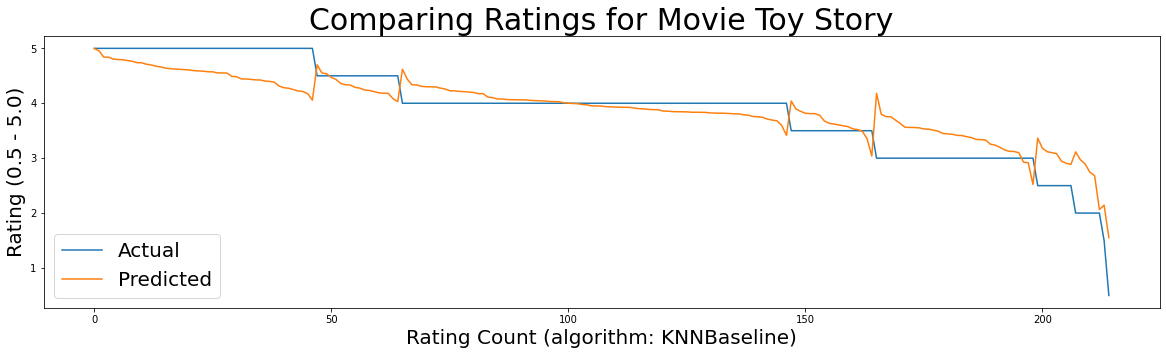

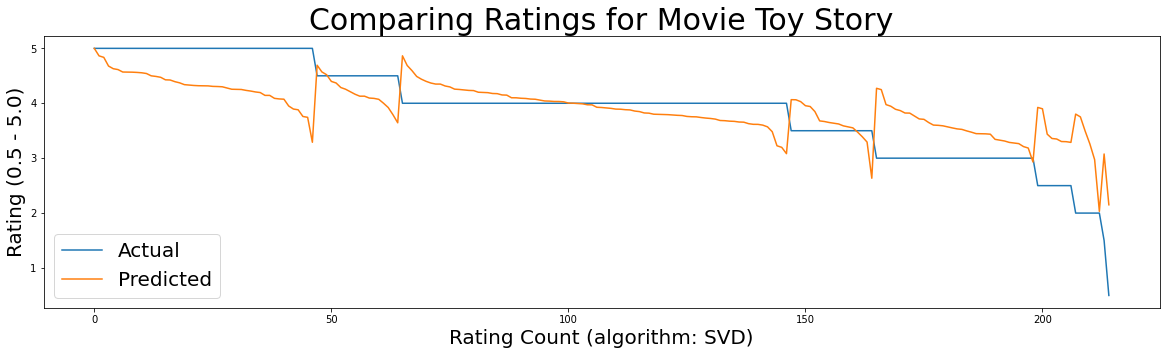

In [35]:
for algo in [algo_knn, algo_svd] :
    bring_it_together(1, 'Toy Story', ratings, algo)

The movie doesn't have that many low ratings. The algorithms cannot catch this.

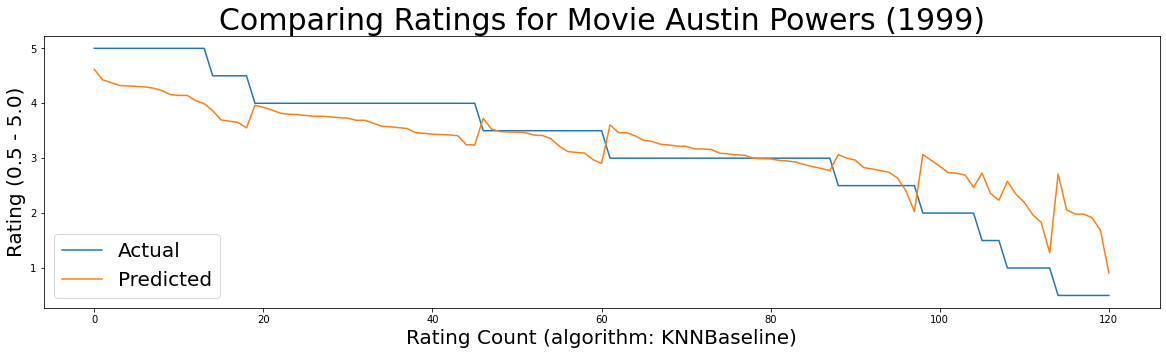

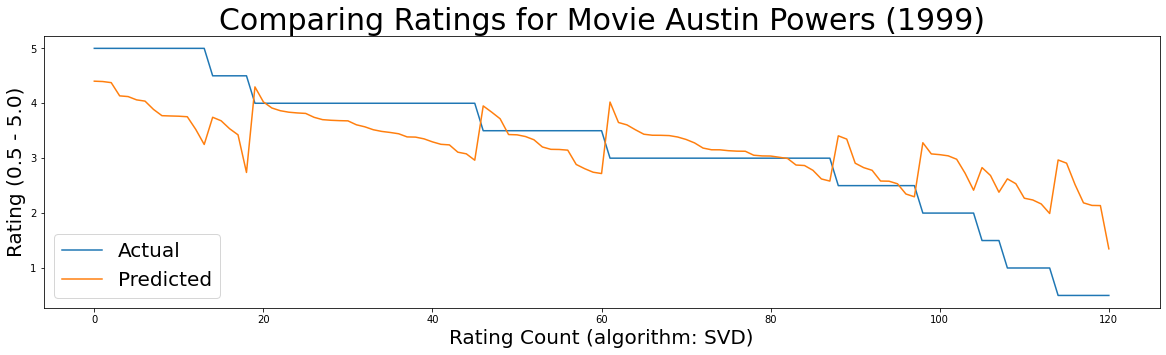

In [36]:
ratings.query('rating == 0.5').groupby('movieId').count().sort_values(by='rating')
movies.query('movieId == 2683')

for algo in [algo_knn, algo_svd] :
    bring_it_together(2683, 'Austin Powers (1999)', ratings, algo)

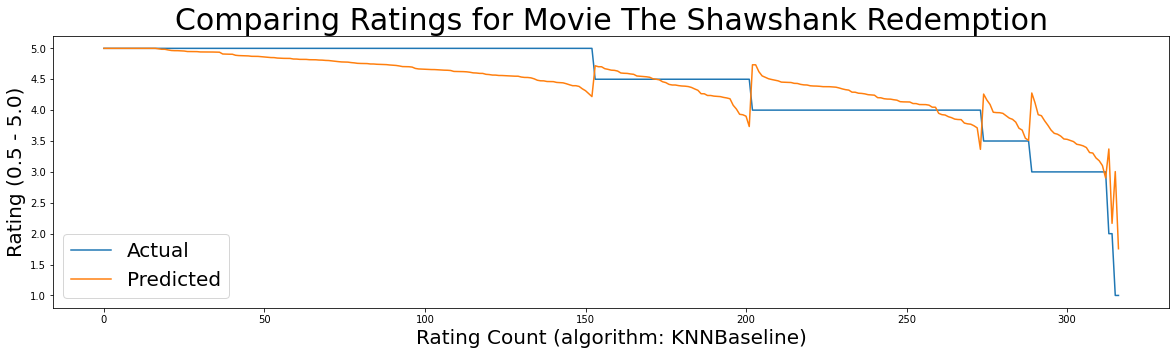

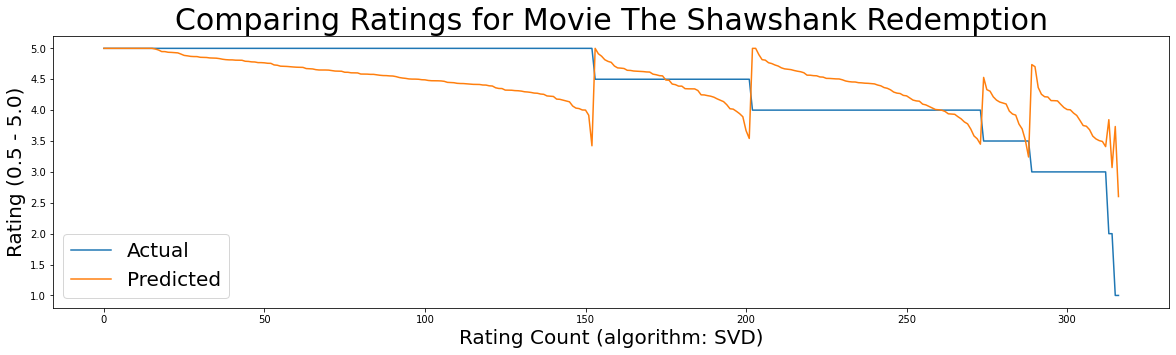

In [37]:
for algo in [algo_knn, algo_svd] :
    bring_it_together(318, 'The Shawshank Redemption', ratings, algo)

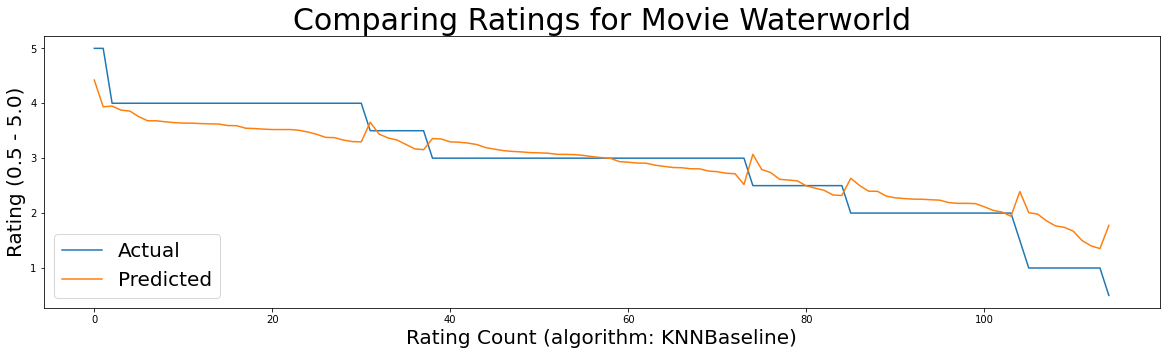

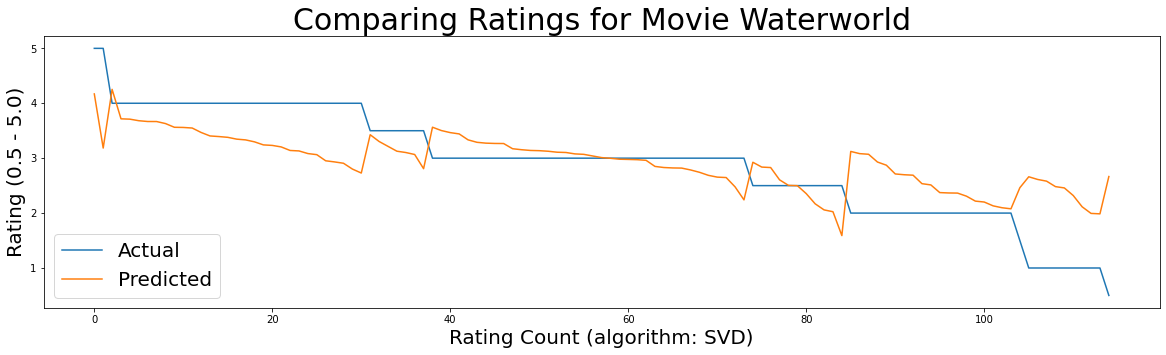

In [38]:
for algo in [algo_knn, algo_svd] :
    bring_it_together(208, 'Waterworld', ratings, algo)

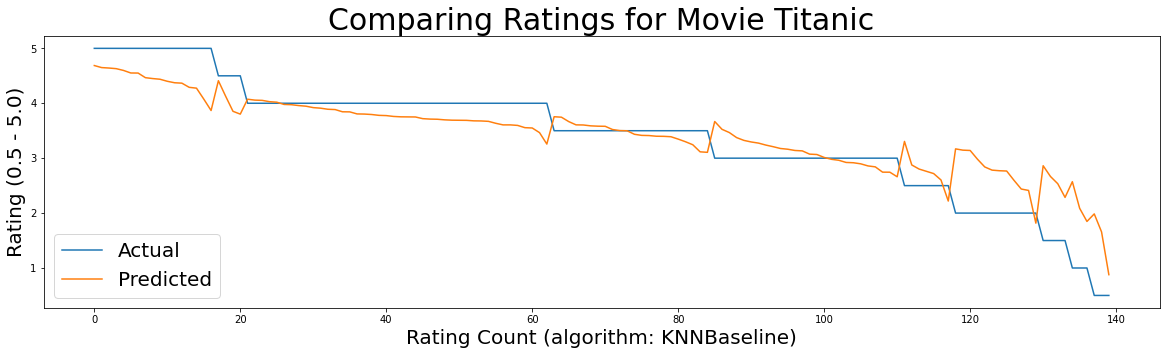

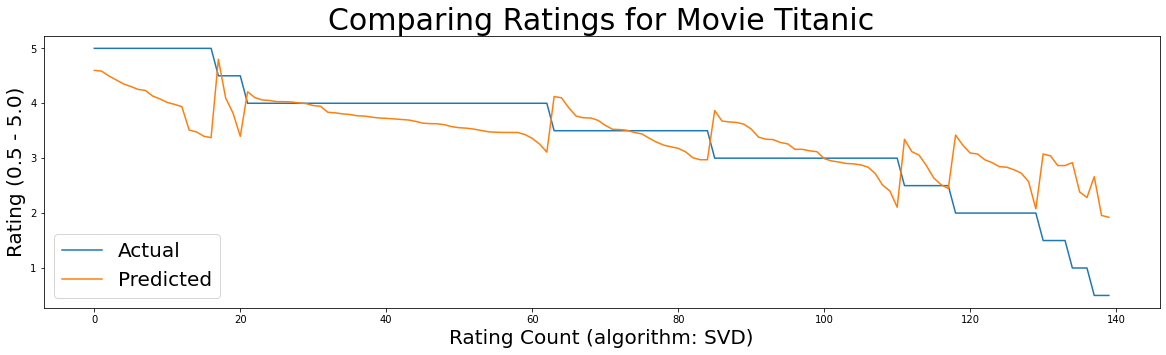

In [39]:
for algo in [algo_knn, algo_svd] :
    bring_it_together(1721, 'Titanic', ratings, algo)

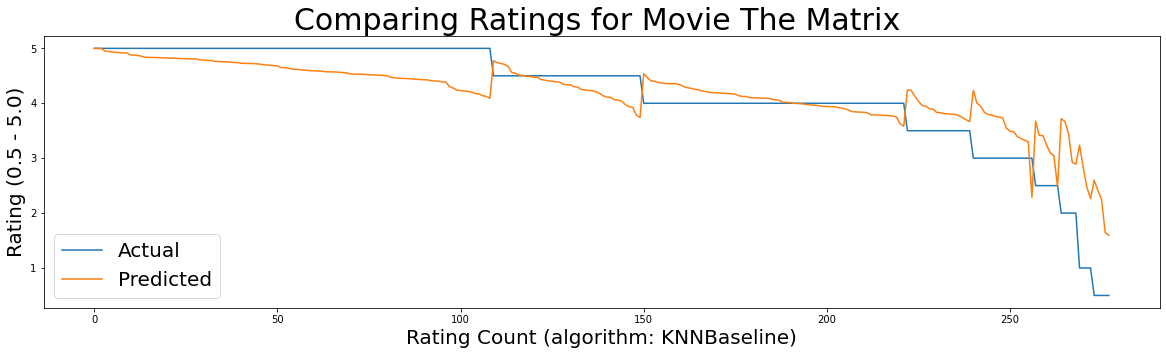

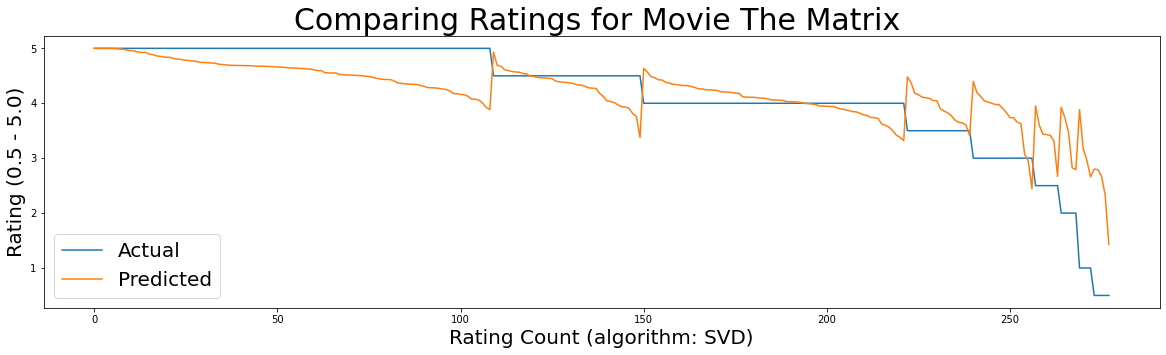

In [40]:
for algo in [algo_knn, algo_svd] :
    bring_it_together(2571, 'The Matrix ', ratings, algo)

## Result: **SVD** and **KNNBaseline (item-based)** are selected for further processing.

(SlopeOne had the worst RMSE values and SVDpp did not yield any real advantage, especially when regarding the longer fitting time.)